In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
stores = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
holidays_events = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('store-sales-time-series-forecasting/oil.csv')

### **Data Processing**

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
# Merge df with stores data
df = pd.merge(df, stores, how='left', on='store_nbr').drop('id', axis=1)

In [6]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
# Selecting only unique national holiday and event dates
holidays_events = holidays_events.query('type != "Work Day" and transferred == False and locale_name == "Ecuador"').query('~date.duplicated()')[['date', 'type', 'description']]

# Convert date features to a datetime object
holidays_events.date = pd.to_datetime(holidays_events.date)
df.date = pd.to_datetime(df.date)

# Converting relevant types into Holiday value
holidays_events.type = holidays_events.type.apply(lambda x: 'Holiday' if x in ['Holiday', 'Additional', 'Transfer', 'Bridge'] else 'Event')

# Rename column to avoid clashing with the type feature that is already in the main dataframe
holidays_events = holidays_events.rename(columns={'type': 'h_e_type'})

# Merge and fill missing values on non-holiday or event dates
df = df.merge(holidays_events, on='date', how='left').fillna('None')
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,h_e_type,description
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano


In [8]:
# Oil commodity not traded on weekends and some holidays, which causes the dates to be non-equidistant
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
# Create a dataframe with equidistant dates
all_dates = pd.DataFrame({'date': pd.date_range('2013-01-01', '2017-08-31')})

# Convert date feature to datetime object
oil.date = oil.date.astype('datetime64[ns]')

# Merge both dataframes
oil_full = all_dates.merge(oil, how='left', on='date')

# Fill in the new missing values
oil_full.dcoilwtico = oil_full.dcoilwtico.interpolate(method='linear').fillna(oil.dcoilwtico[:5].mean())

In [10]:
df = df.merge(oil_full, how='left', on='date')
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,h_e_type,description,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075


In [11]:
# Reduce memory usage
df = df.astype({'store_nbr': 'int8', 
                  'family': 'category', 
                  'sales': 'float32', 
                  'onpromotion': 'int16', 
                  'city': 'category', 
                  'state': 'category', 
                  'type': 'category', 
                  'h_e_type': 'category', 
                  'description': 'category',
                  'cluster': 'int8', 
                  'dcoilwtico': 'float16'
                  })

In [12]:
print(df.info(), "\n", df.isna().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int8          
 2   family       category      
 3   sales        float32       
 4   onpromotion  int16         
 5   city         category      
 6   state        category      
 7   type         category      
 8   cluster      int8          
 9   h_e_type     category      
 10  description  category      
 11  dcoilwtico   float16       
dtypes: category(6), datetime64[ns](1), float16(1), float32(1), int16(1), int8(2)
memory usage: 91.6 MB
None 
 date           False
store_nbr      False
family         False
sales          False
onpromotion    False
city           False
state          False
type           False
cluster        False
h_e_type       False
description    False
dcoilwtico     False
dtype: bool


### **Data Exploration**

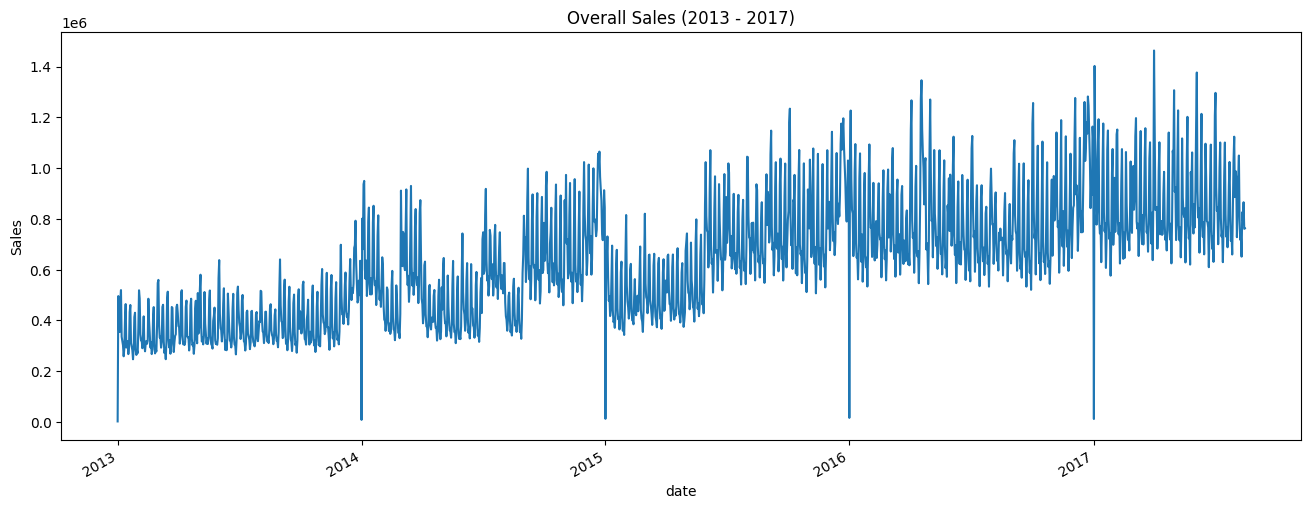

In [13]:
# Sales overview
df.groupby('date').sales.sum().plot(ylabel='Sales', title='Overall Sales (2013 - 2017)', figsize=(16, 6));

* The outliers near 0 happened on New Year's Day, which most probably was because stores were closed on that day.
* Rather strong fluctuations in sales on shorter time frames.

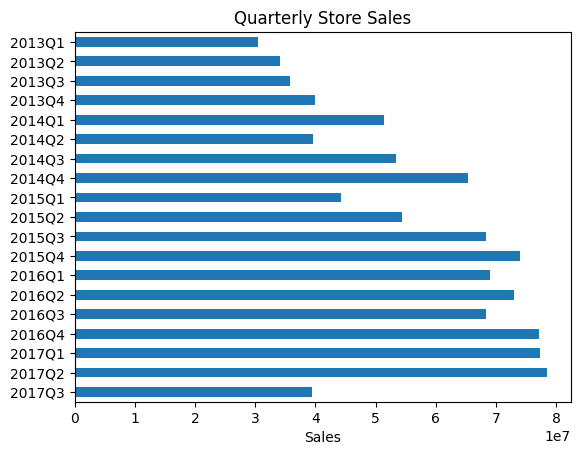

In [14]:
# Quarterly sales over the years
df.groupby(pd.Grouper(key='date', freq='BQ')).sales.sum().to_period("Q").sort_index(ascending=False).plot(kind='barh', ylabel='', xlabel='Sales', title='Quarterly Store Sales');



*   Overall, there was an overall growth trend in sales.
*   Sales generally increased quarter-over-quarter.
*   The drastic drop in 2017Q3 is because the input data only consists of the first half of that period.



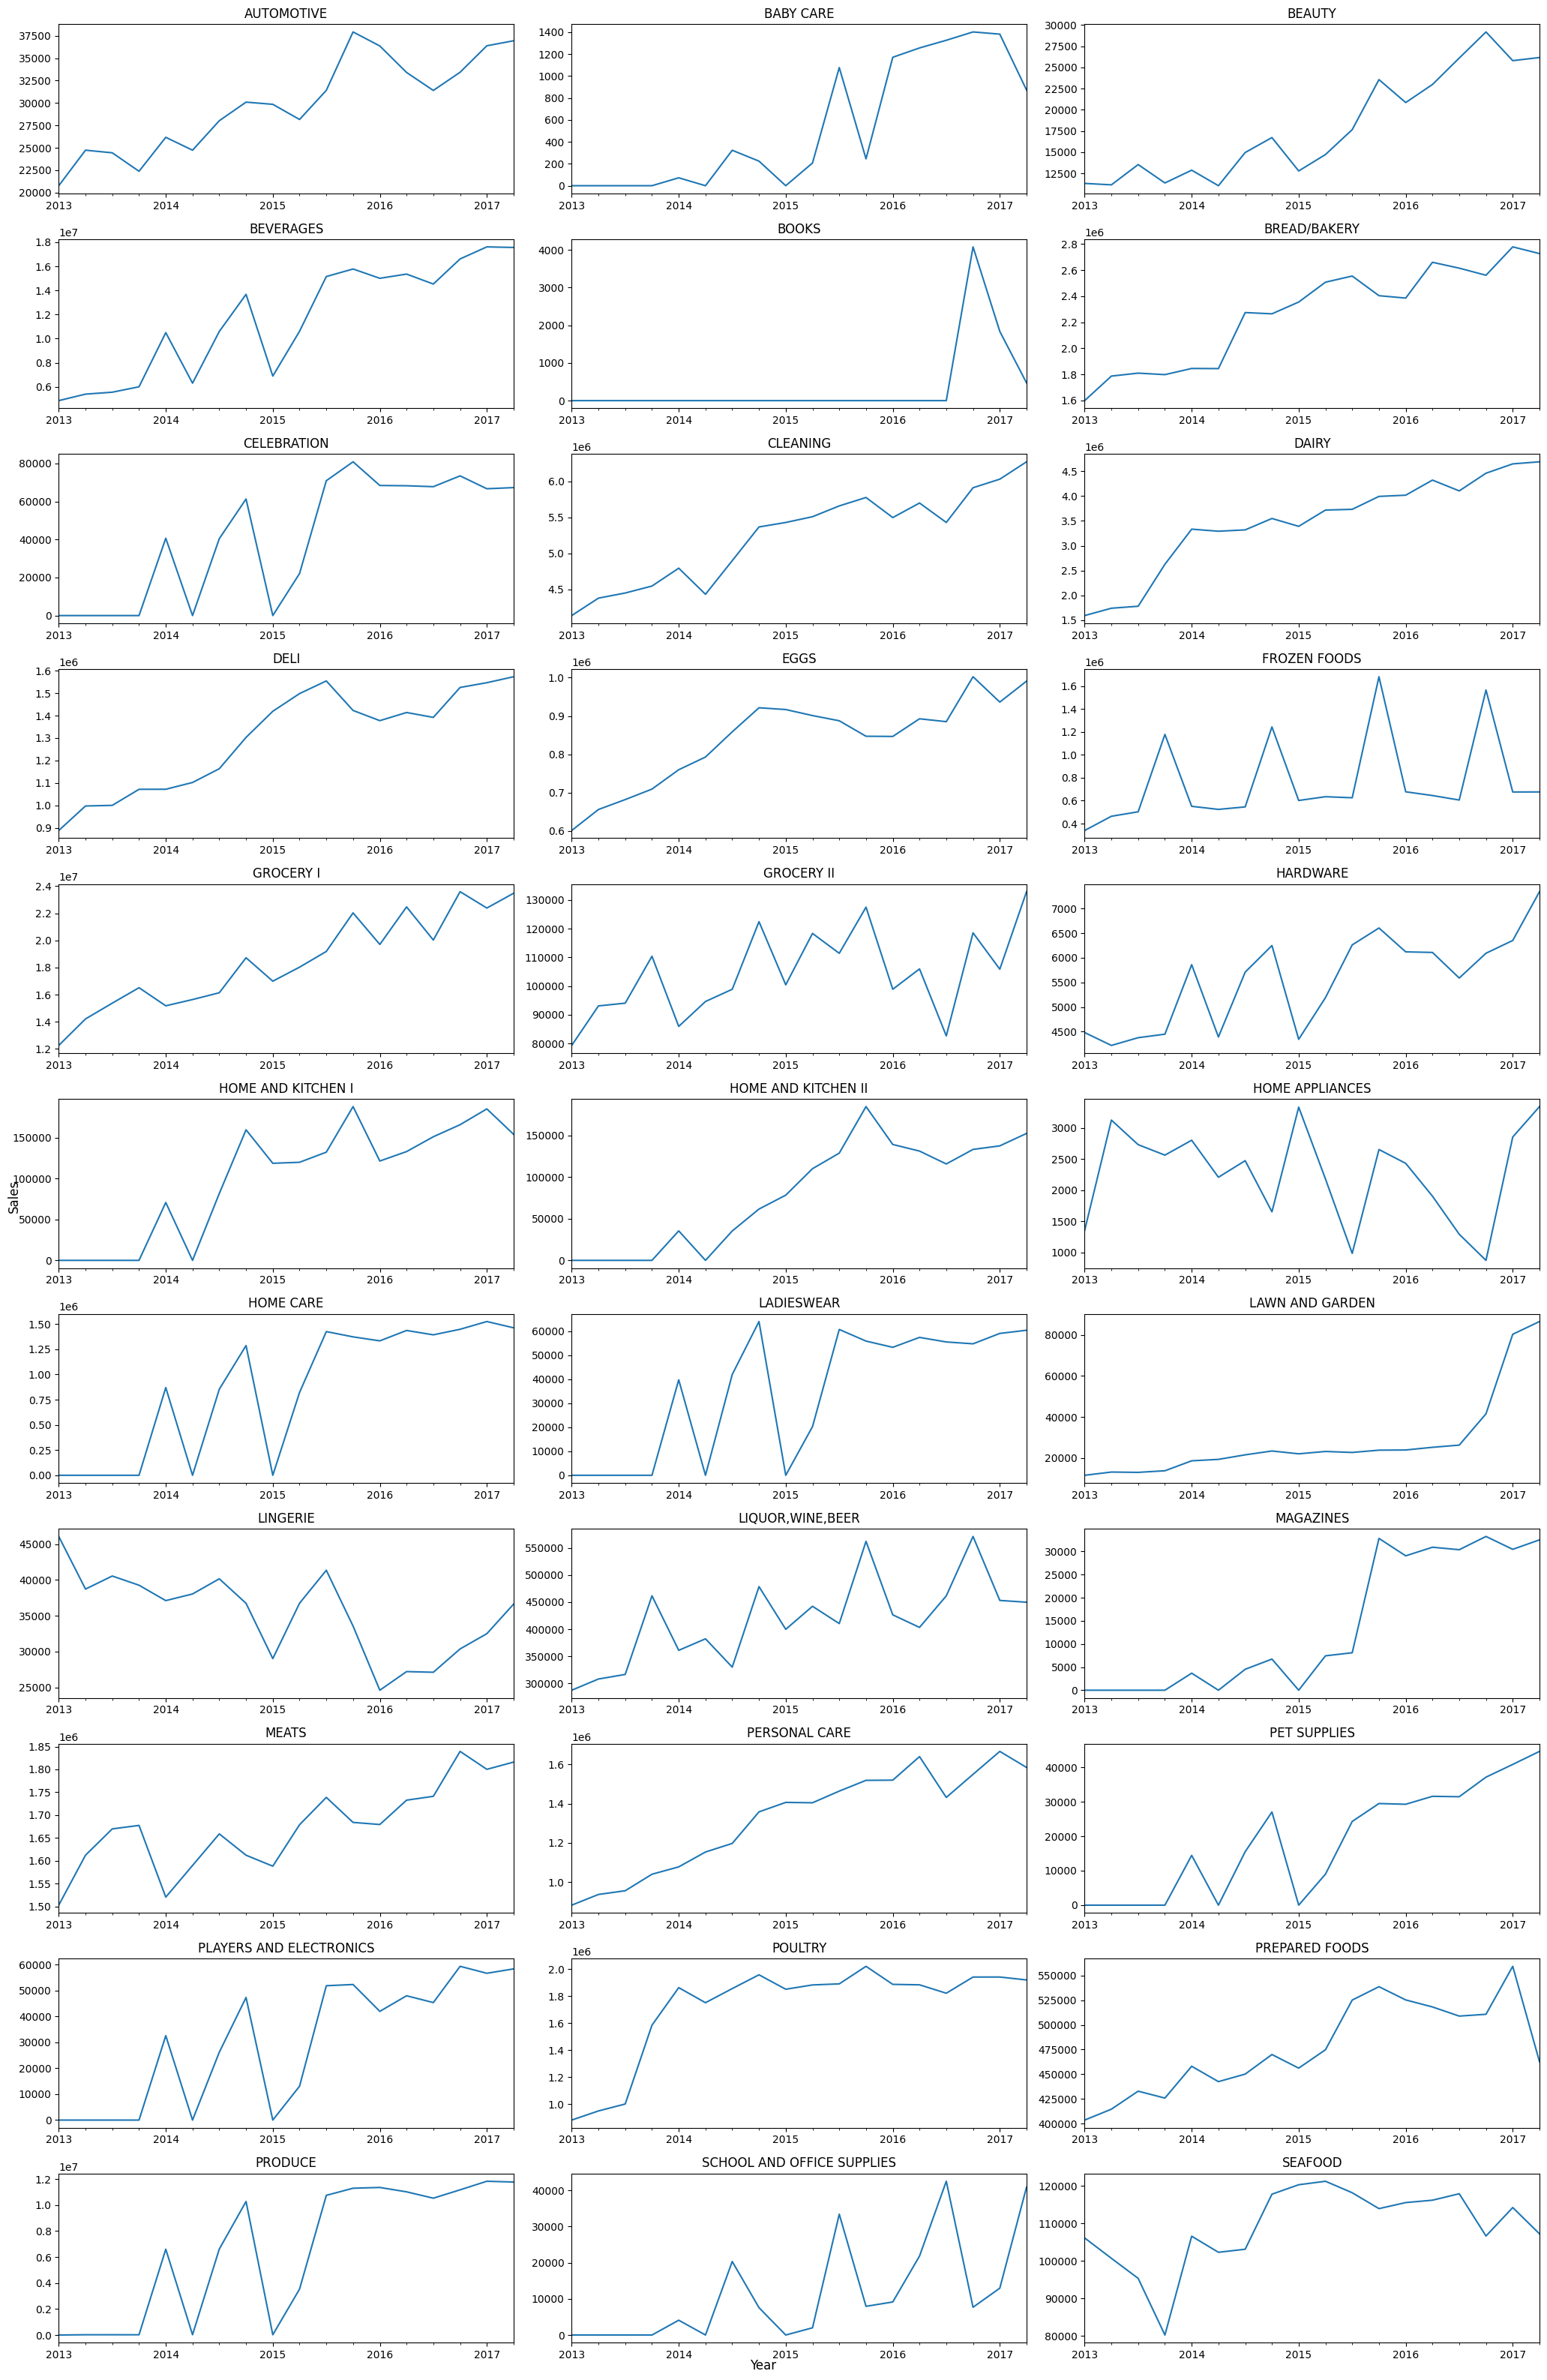

In [15]:
# Quarterly sales by product family, excluding the incomplete 2017Q3 data
temp_df = df.query('date < "2017/07"')
temp_df.family.nunique() # 33 unique product families
family_names = temp_df.family.unique() 
fig = plt.figure(figsize=(21, 32))

for i, family in enumerate(family_names):
  ax = fig.add_subplot(11, 3, i+1)
  temp_df.query('family == @family').groupby(pd.Grouper(key='date', freq='BQ')).sales.sum().plot(xlabel='')
  plt.title(family)

fig.supxlabel('Year')
fig.supylabel('Sales')
plt.tight_layout()

*   Many product families such as produce and pet supplies saw 0 sales in some quarters, typically in 2014Q1 and 2014Q4.
*   Books product family launched only during 2016Q4.
*   All except lingerie and home appliances saw a general growth trend across the years.



In [16]:
# Investigate product families with 0 sales
quarterly_sales = df.set_index('date').to_period('Q').groupby(['date', 'family']).sales.sum()
quarterly_sales[quarterly_sales == 0].reset_index().date.value_counts().sort_index()

2013Q1    11
2013Q2    11
2013Q3    11
2013Q4    11
2014Q1     1
2014Q2    11
2014Q3     1
2014Q4     1
2015Q1     9
2015Q2     1
2015Q3     1
2015Q4     1
2016Q1     1
2016Q2     1
2016Q3     1
Freq: Q-DEC, Name: date, dtype: int64

In [17]:
quarters_0_sales = ['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q2', '2015Q1']
quarterly_sales[quarterly_sales == 0].unstack().loc[quarters_0_sales]

family,BABY CARE,BOOKS,CELEBRATION,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME CARE,LADIESWEAR,MAGAZINES,PET SUPPLIES,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES
date,,,,,,,,,,,
2013Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015Q1,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


*   The quarters with a high number of product families with 0 sales can be explained by those product families not being on sale in those periods.
*   For the quarters with 1 product family with 0 sales, it is because of the books family not being launched yet.

In [18]:
# As per the metadata, wages in Ecuador's public sector are paid every two weeks: on the 15th and on the last day of the month, which could affect sales
# I want to investigate its effect, specifically by looking at sales from these days + 6 days compared with the rest of the days in the month 
# Excluding values after 2017/08 because it is incomplete
from pandas.tseries.offsets import MonthEnd
monthend_list = ((df.query('date < "2017/08"').date.drop_duplicates() + MonthEnd()).dt.strftime("%Y/%m/%d")).unique() # Getting all the unique months and their respective end month dates in the data
monthend_filter = []
for month in monthend_list:
  monthend_filter.extend(pd.date_range(month, periods=7))

midmonth_list = df.query('date < "2017/08"').date[df.query('date < "2017/08"').date.dt.day == 15].dt.strftime("%Y/%m/%d").unique()
midmonth_filter = []
for month in midmonth_list:
  midmonth_filter.extend(pd.date_range(month, periods=7))

# Check if lists are right
combined_filter = monthend_filter + midmonth_filter
print('Month end + 6 days:', monthend_filter[:7], "\n", '15th of month + 6 days:', midmonth_filter[:7])

Month end + 6 days: [Timestamp('2013-01-31 00:00:00', freq='D'), Timestamp('2013-02-01 00:00:00', freq='D'), Timestamp('2013-02-02 00:00:00', freq='D'), Timestamp('2013-02-03 00:00:00', freq='D'), Timestamp('2013-02-04 00:00:00', freq='D'), Timestamp('2013-02-05 00:00:00', freq='D'), Timestamp('2013-02-06 00:00:00', freq='D')] 
 15th of month + 6 days: [Timestamp('2013-01-15 00:00:00', freq='D'), Timestamp('2013-01-16 00:00:00', freq='D'), Timestamp('2013-01-17 00:00:00', freq='D'), Timestamp('2013-01-18 00:00:00', freq='D'), Timestamp('2013-01-19 00:00:00', freq='D'), Timestamp('2013-01-20 00:00:00', freq='D'), Timestamp('2013-01-21 00:00:00', freq='D')]


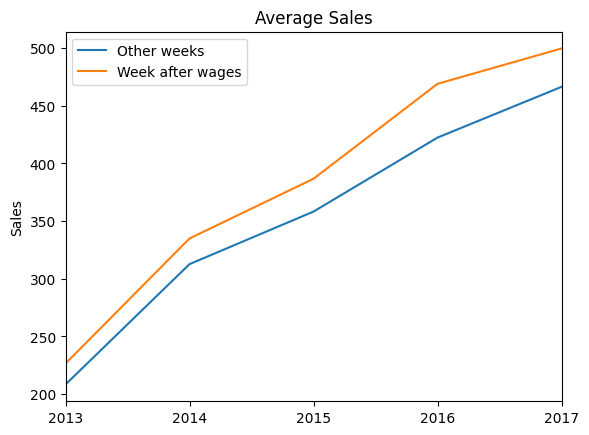

In [19]:
# Visualising the average difference in sales between wage weeks and non-wage weeks
df.query('date < "2017/08" and date not in @combined_filter').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
df.query('date in @combined_filter').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
plt.legend(['Other weeks', 'Week after wages'])
plt.xlabel('')
plt.ylabel('Sales')
plt.title('Average Sales');

Average sales saw an uplift in the week following public sector wages being paid out.

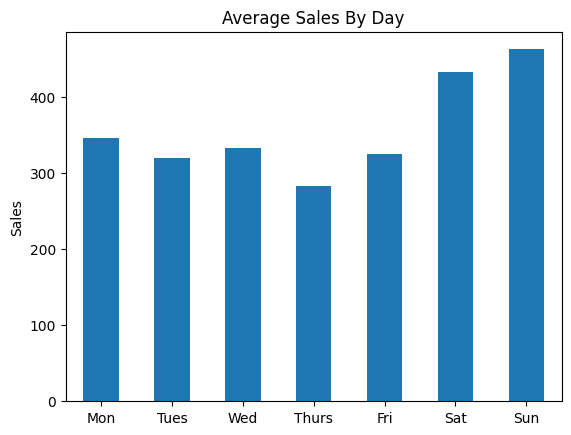

In [20]:
# Check for weekly seasonality
df['dayofweek'] = df.date.dt.dayofweek
df.groupby('dayofweek').sales.mean().plot.bar(xlabel='', ylabel='Sales', title='Average Sales By Day')
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], rotation=0);

* Sales on the weekends were much higher on average than sales on weekdays.
* Sales on Thursdays were the lowest on average, which suggests that many Ecuadorians have a habit of shopping for their weekly groceries at either the start or end of the week.

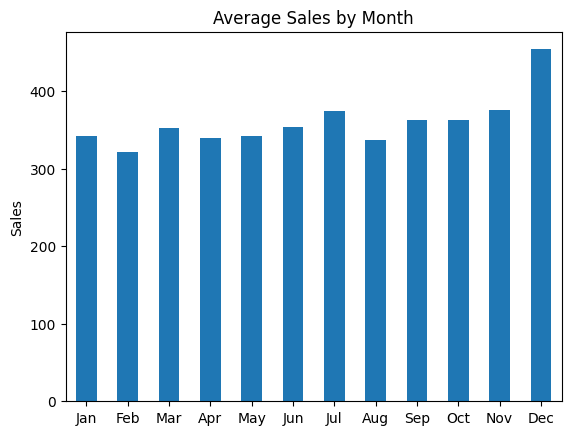

In [21]:
# Check for monthly seasonality
df['month'] = df.date.dt.month
df.groupby('month').sales.mean().plot.bar(title='Average Sales by Month', ylabel='Sales', xlabel='')
plt.gca().set_xticklabels(pd.date_range('2013', periods=12, freq='M').strftime("%b").to_list(), rotation=0);

Sales experience a slight increase across the year, with Dec experiencing significantly higher sales.

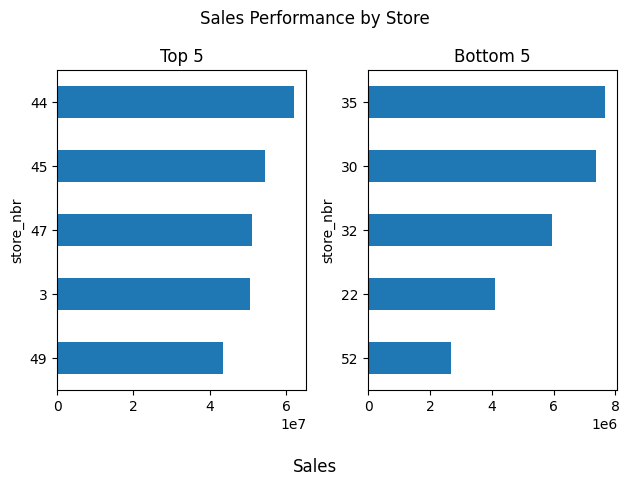

In [22]:
# Find out the sales performance by store
df.store_nbr.nunique() # 54 unique stores

# Top 5 and bottom 5 over the years
fig, ax = plt.subplots(1, 2)
df.groupby('store_nbr').sales.sum().nlargest(5).sort_values().plot.barh(ax=ax[0], title='Top 5')
df.groupby('store_nbr').sales.sum().nsmallest(5).plot.barh(ax=ax[1], title='Bottom 5')
fig.supxlabel('Sales')
plt.suptitle('Sales Performance by Store', fontsize=12)
plt.tight_layout()

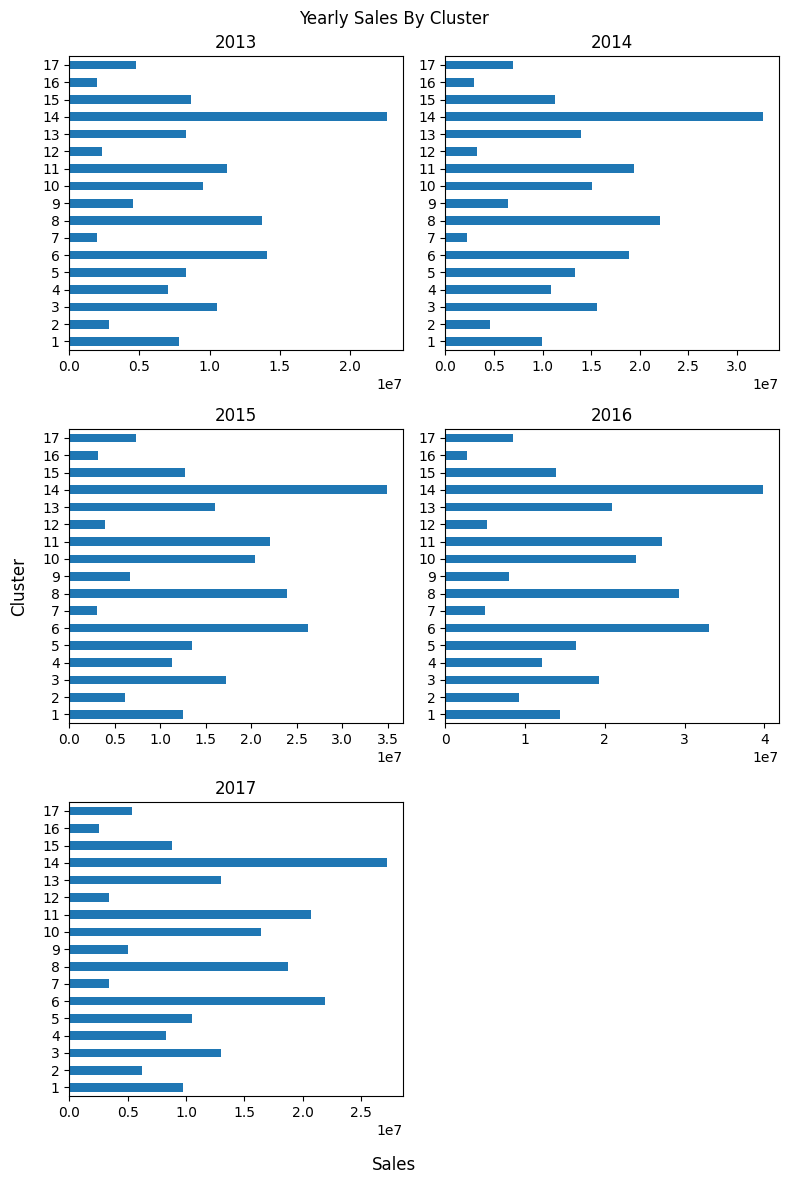

In [23]:
# Yearly sales performance by cluster, where cluster is a grouping of similar stores
cluster_sales = df.set_index('date').to_period('Y').groupby(['date', 'cluster']).sales.sum()

fig = plt.figure(figsize=(8, 12))
years = ['2013', '2014', '2015', '2016', '2017']

for i, year in enumerate(years):
  fig.add_subplot(3, 2, i+1)
  cluster_sales.xs(year).plot.barh(title=f'{year}', ylabel='')

fig.suptitle('Yearly Sales By Cluster')
fig.supylabel('Cluster')
fig.supxlabel('Sales')
plt.tight_layout()

*   The sales performance by cluster looks identical year-over-year.
*   Cluster 14's sales performance was heads and shoulders above the rest, followed by a group of close competitors: clusters 11, 8, and 6.
*   Clusters 16, 12, and 7 were the worst performers.







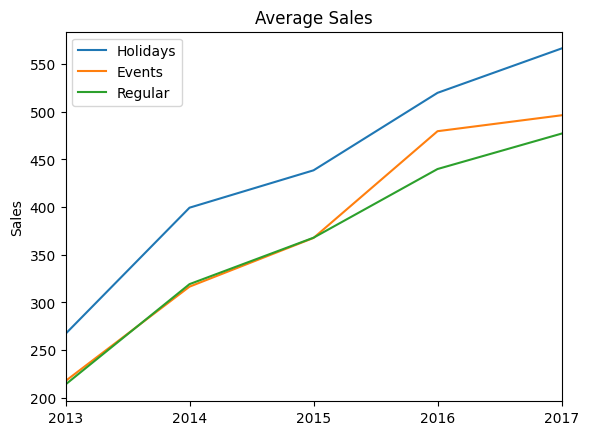

In [24]:
# Investigate the relationship between holidays, events, and sales
df.query('h_e_type in ["Holiday", "Transfer", "Additional", "Bridge"]').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
df.query('h_e_type == "Event"').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
df.query('h_e_type not in ["Holiday", "Transfer", "Additional", "Bridge"]').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()

plt.legend(['Holidays', "Events", 'Regular'])
plt.xlabel('')
plt.ylabel('Sales')
plt.title('Average Sales');

* Sales during the holidays were significantly greater than on regular days.
* Sales during events and regular days were for the most part the same, excluding a spike in 2016 which could be explained by the 7.8 magnitude earthquake that struck Ecuador in April. 

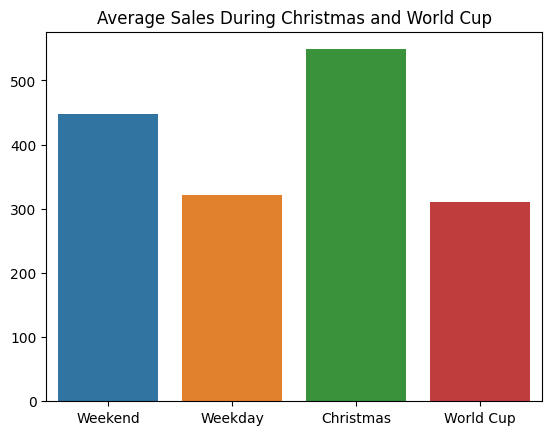

In [25]:
# Investigate the relationship of the World Cup and Christmas with sales
events_df = pd.DataFrame({'weekend': df.query('dayofweek in [5, 6]').sales.mean(),
                            'weekday': df.query('dayofweek not in [5, 6]').sales.mean(),
                            'christmas': df.query('description.str.contains("Navidad")').sales.mean(),
                            'worldcup': df.query('description.str.contains("Mundial de futbol")').sales.mean()},
                            index=['sales'])

sns.barplot(events_df)
plt.gca().set_xticklabels(['Weekend', 'Weekday', 'Christmas', 'World Cup'])
plt.title('Average Sales During Christmas and World Cup');

Sales were significantly higher during the Christmas period, which helps explain the higher sales in December. 

In [26]:
# In April 2016, a magnitude 7.8 earthquake struck Ecuador. I will explore the impact of the earthquake on sales
df.description.unique() # Find the description of the earthquake event
earthquake_dates = df.query('description.str.contains("Terremoto Manabi")').date.unique()
earthquake_dates

array(['2016-04-16T00:00:00.000000000', '2016-04-17T00:00:00.000000000',
       '2016-04-18T00:00:00.000000000', '2016-04-19T00:00:00.000000000',
       '2016-04-20T00:00:00.000000000', '2016-04-21T00:00:00.000000000',
       '2016-04-22T00:00:00.000000000', '2016-04-23T00:00:00.000000000',
       '2016-04-24T00:00:00.000000000', '2016-04-25T00:00:00.000000000',
       '2016-04-26T00:00:00.000000000', '2016-04-27T00:00:00.000000000',
       '2016-04-28T00:00:00.000000000', '2016-04-29T00:00:00.000000000',
       '2016-04-30T00:00:00.000000000', '2016-05-02T00:00:00.000000000',
       '2016-05-03T00:00:00.000000000', '2016-05-04T00:00:00.000000000',
       '2016-05-05T00:00:00.000000000', '2016-05-06T00:00:00.000000000',
       '2016-05-08T00:00:00.000000000', '2016-05-09T00:00:00.000000000',
       '2016-05-10T00:00:00.000000000', '2016-05-11T00:00:00.000000000',
       '2016-05-12T00:00:00.000000000', '2016-05-13T00:00:00.000000000',
       '2016-05-14T00:00:00.000000000', '2016-05-15

The 2016 earthquake event was marked out on the calendar for 1 month from its start. I will compare sales in this month compared with the months preceding and following, and if need be adjust the window accordingly.

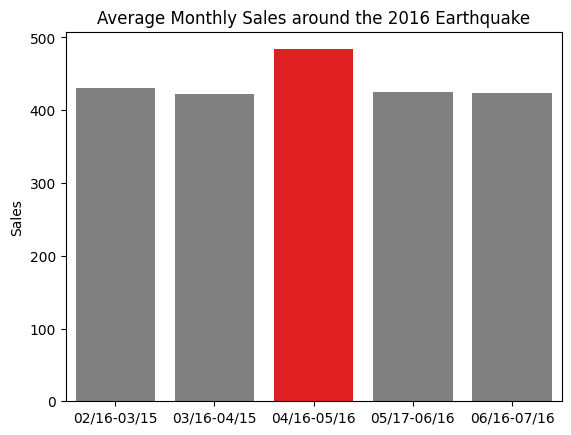

In [27]:
previous_month_1 = pd.date_range('2016-03-16', '2016-04-15')
previous_month_2 = pd.date_range('2016-02-16', '2016-03-15')
following_month_1 = pd.date_range('2016-05-17', '2016-06-16')
following_month_2 = pd.date_range('2016-06-17', '2016-07-16')

eq_df = pd.DataFrame([df.query('date in @previous_month_2').sales.mean(),
                    df.query('date in @previous_month_1').sales.mean(),
                    df.query('description.str.contains("Terremoto Manabi")').sales.mean(),
                    df.query('date in @following_month_1').sales.mean(),
                    df.query('date in @following_month_2').sales.mean()],
                    index=['02/16-03/15', '03/16-04/15', '04/16-05/16', '05/17-06/16', '06/16-07/16'],
                    columns=['Sales'])

colours = ['grey' if (x < eq_df.Sales.max()) else 'red' for x in eq_df.Sales]
sns.barplot(x=eq_df.index, y=eq_df.Sales, palette=colours)
plt.title('Average Monthly Sales around the 2016 Earthquake');

The earthquake month had elevated sales, probably because people rallied in relief efforts and donated necessities to victims.

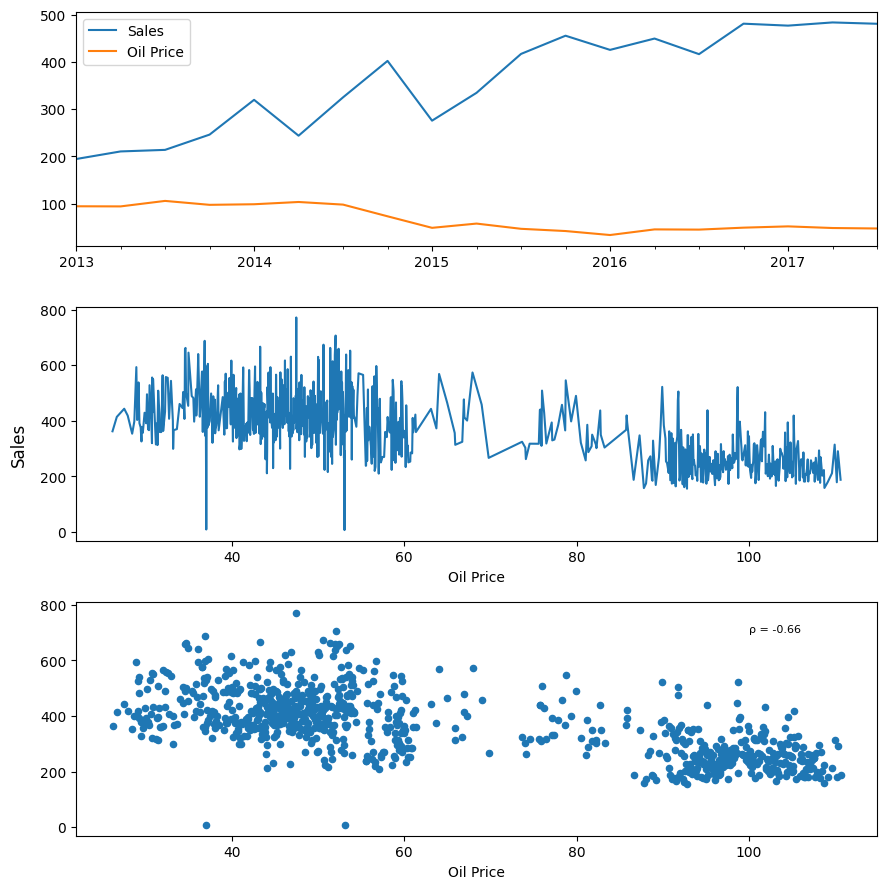

In [28]:
# Investigate the relationship between oil prices and sales
fig, ax = plt.subplots(3, figsize=(9, 9))
df.groupby(pd.Grouper(key='date', freq='BQ'))[['sales', 'dcoilwtico']].mean().to_period('Q').plot(ax=ax[0], xlabel='')
ax[0].legend(['Sales', 'Oil Price'])
df.groupby('dcoilwtico').sales.mean().plot(ax=ax[1], xlabel='Oil Price')
df.groupby('dcoilwtico').sales.mean().reset_index().plot.scatter(x='dcoilwtico', y='sales', ax=ax[2], xlabel='Oil Price', ylabel='')
plt.text(100, 700, f"ρ = {df.groupby('dcoilwtico').sales.mean().to_frame().reset_index().corr().iloc[0, 1]:.2f}", {'fontsize': 8})
fig.supylabel('Sales')
plt.tight_layout()

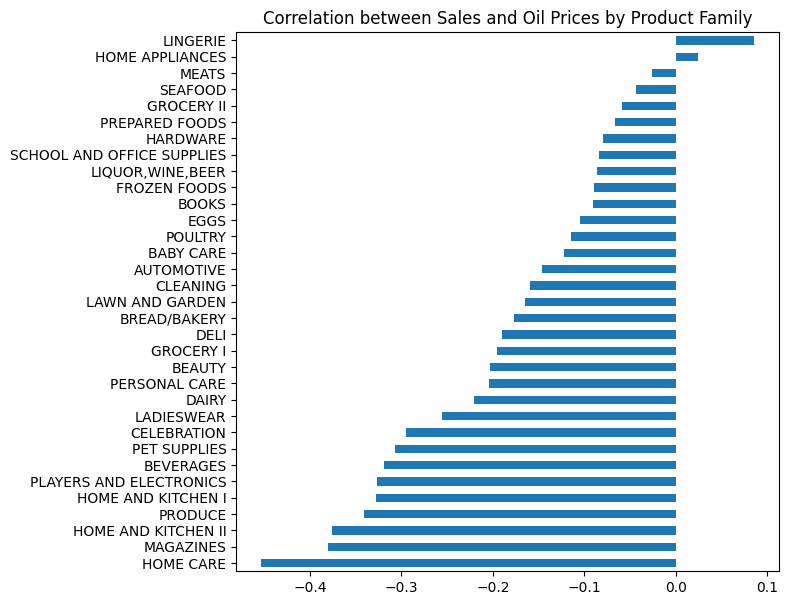

In [29]:
df.groupby('family')[['sales','dcoilwtico']].corr().loc[::2, 'dcoilwtico'].unstack().sort_values('sales').plot.barh(figsize=(7, 7), ylabel='', title='Correlation between Sales and Oil Prices by Product Family', legend=False);

* Overall, sales and oil prices shared a moderate inverse relationship. 
* The impact of oil prices on sales varied quite a bit from product family to product family.

### **Summary of Data Exploration:**
1. Overall sales increased year-over-year.
2. The sales of most product families increased over the years.
3. Book product family was the latest launch: in 2016Q4.
4. Sales saw an uplift the week after public wages were paid out on the 15th and end of every month.
5. Weekend sales were significantly greater than weekday sales of which Thursday was the worst.
6. Sales experienced a slight increase across the year, with Dec experiencing significantly higher sales because of Christmas.
7. Holiday sales were significantly higher than regular or even event days, where the latter two types are essentially the same when it comes to sales.
8. The 2016 earthquake elevated sales rather significantly.
9. Generally as oil prices rose, sales dipped.


### **Feature Engineering**

In [30]:
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,h_e_type,description,dcoilwtico,dayofweek,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.125,1,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.125,1,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.125,1,1
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.125,1,1
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.125,1,1


In [31]:
# Neutralise the elevated sales effect that the 2016 earthquake had on sales
eq_df # 04/16 - 05/16 refers to the 'earthquake month'

,Sales
02/16-03/15,429.951630
03/16-04/15,421.806458
04/16-05/16,483.729584
05/17-06/16,425.623444
06/16-07/16,423.774078


In [32]:
# % difference in mean sales during 'earthquake month' and the month before and month after
sales_diff = (eq_df.iloc[2] - eq_df.iloc[[1, 3]].mean()) / eq_df.iloc[2]

# Apply transformation
df.loc[(df.date >= "2016-04-16") & (df.date <= "2016-05-16"), 'sales'] = df.loc[(df.date >= "2016-04-16") & (df.date <= "2016-05-16"), 'sales'] * (1 - sales_diff.values)

# As observed earlier, holidays have a significant effect on sales while events do not
# Rename h_e_type to holiday
df = df.rename(columns={'h_e_type': 'holidays'})

# Encode Holiday values as 1, others as 0
df.holidays = df.holidays.apply(lambda x: 1 if x in ['Holiday', 'Additional', 'Transfer', 'Bridge'] else 0).fillna(0)

# Drop the description feature
df = df.drop(columns=['description'])

# Add time features
df['year'] = df.date.dt.year
df['dayofyear'] = df.date.dt.dayofyear
df['quarter'] = df.date.dt.quarter
df['week'] = df.date.dt.isocalendar().week

# Add weekend feature where 1 = a weekend, 0 = weekday
df['weekend'] = df.dayofweek.apply(lambda x: 1 if x == 6 or x == 7 else 0)

# Add wageweek feature where 1 = the day of public wages being paid out + 6 days, 0 for the rest
df['wageweek'] = df.date.isin(combined_filter).apply(lambda x: 1 if x==True else 0) # combined_filter defined earlier in data exploration phase

df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holidays,dcoilwtico,dayofweek,month,year,dayofyear,quarter,week,weekend,wageweek
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1,93.125,1,1,2013,1,1,1,0,0
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1,93.125,1,1,2013,1,1,1,0,0
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1,93.125,1,1,2013,1,1,1,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1,93.125,1,1,2013,1,1,1,0,0
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1,93.125,1,1,2013,1,1,1,0,0


In [33]:
# Remove these records with 0 sales in a quarter
quarterly_sales[quarterly_sales == 0].unstack().loc[quarters_0_sales]

family,BABY CARE,BOOKS,CELEBRATION,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME CARE,LADIESWEAR,MAGAZINES,PET SUPPLIES,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES
date,,,,,,,,,,,
2013Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015Q1,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Get the list of product families between 2013Q1 - 2014Q2
family_list = quarterly_sales[quarterly_sales == 0].unstack().loc[quarters_0_sales].columns.to_list()

# Removal of records
df = df.loc[~((df.date >= "2013") & (df.date < "2014") & (df.sales == 0) & (df.family.isin(family_list)))]

# Get the list for 2015Q1
family_list.remove('HOME AND KITCHEN I')
family_list.remove('HOME AND KITCHEN II')

# Removal of records
df = df.loc[~((df.date >= "2015") & (df.date < "2015-04") & (df.sales == 0) & (df.family.isin(family_list)))]

# Removal of all book sales records before its launch in 2016Q4
df = df.loc[~(((df.date < "2016-07") & (df.family == "BOOKS")))]

In [35]:
# Reduce memory usage
df = df.astype({'dayofweek': 'int8',
                'year': 'int16',
                'month': 'int8',
                'dayofyear': 'int16',
                'quarter': 'int8',
                'week': 'int8',
                'weekend': 'int8',
                'wageweek': 'int8',
                'holidays': 'int8'    
                })

### **Model Training**

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool

In [37]:
X = df.drop(columns='sales')
y = df[['date', 'sales']]

X_train = X.query('date <= "2016-11-15"')
X_test = X.query('date > "2016-11-15"')

y_train = y.query('date <= "2016-11-15"').drop(columns='date')
y_test = y.query('date > "2016-11-15"').drop(columns='date')

In [38]:
cat_features = ['family', 'city', 'state', 'type']
train_pool = Pool(X_train, y_train, cat_features)
test_pool = Pool(X_test, y_test, cat_features)

In [39]:
cbr = CatBoostRegressor(iterations=1000, 
                        learning_rate = 0.1,
                        depth=8,
                        random_seed=4, 
                        one_hot_max_size=33,
                        verbose=50,
                        task_type='GPU')
cbr.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

0:	learn: 1015.4894110	test: 1291.4774784	best: 1291.4774784 (0)	total: 28.2ms	remaining: 28.1s
50:	learn: 453.5273780	test: 512.7702663	best: 512.7702663 (50)	total: 1.26s	remaining: 23.4s
100:	learn: 399.2912151	test: 464.3080503	best: 464.3080503 (100)	total: 2.51s	remaining: 22.4s
150:	learn: 367.2596306	test: 432.5286946	best: 432.5286946 (150)	total: 3.76s	remaining: 21.1s
200:	learn: 346.1669271	test: 416.6776225	best: 416.6776225 (200)	total: 5.1s	remaining: 20.3s
250:	learn: 330.1606843	test: 400.3629752	best: 400.3629752 (250)	total: 6.3s	remaining: 18.8s
300:	learn: 316.5893275	test: 389.3868761	best: 389.3234357 (299)	total: 7.53s	remaining: 17.5s
350:	learn: 305.5232511	test: 384.5414857	best: 384.5414857 (350)	total: 8.75s	remaining: 16.2s
400:	learn: 296.1770837	test: 380.8122344	best: 380.6564011 (396)	total: 10s	remaining: 14.9s
450:	learn: 288.3806615	test: 375.0358036	best: 375.0358036 (450)	total: 11.3s	remaining: 13.7s
500:	learn: 280.4071075	test: 373.2459055	best

In [40]:
cbr_preds = cbr.predict(X_test)
cbr_preds[cbr_preds < 0] = 0

print(f'Root mean squared error of model: {mean_squared_error(y_test, cbr_preds, squared=False):.2f}')
print(f'Mean absolute error of model: {mean_absolute_error(y_test, cbr_preds):.2f}')

Root mean squared error of model: 366.97
Mean absolute error of model: 111.39


In [41]:
# Simple tuning by reducing learning rate
cbr2 = CatBoostRegressor(iterations=1500, 
                        learning_rate=0.05,
                        depth=8,
                        random_seed=4, 
                        one_hot_max_size=33,
                        verbose=50,
                        task_type='GPU')
cbr2.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

0:	learn: 1053.6452210	test: 1337.0416974	best: 1337.0416974 (0)	total: 25.2ms	remaining: 37.7s
50:	learn: 511.8909081	test: 597.1950155	best: 597.1950155 (50)	total: 1.29s	remaining: 36.6s
100:	learn: 454.9965515	test: 515.5411640	best: 515.5411640 (100)	total: 2.65s	remaining: 36.8s
150:	learn: 423.9892645	test: 484.3525989	best: 484.3525989 (150)	total: 3.91s	remaining: 35s
200:	learn: 400.1110098	test: 462.0375700	best: 462.0375700 (200)	total: 5.25s	remaining: 33.9s
250:	learn: 381.4445535	test: 447.0528425	best: 447.0528425 (250)	total: 6.52s	remaining: 32.4s
300:	learn: 368.6358860	test: 435.1000565	best: 435.1000565 (300)	total: 7.86s	remaining: 31.3s
350:	learn: 357.2039040	test: 425.4952428	best: 425.4952428 (350)	total: 9.21s	remaining: 30.2s
400:	learn: 346.2266847	test: 415.7932563	best: 415.7494764 (399)	total: 10.4s	remaining: 28.6s
450:	learn: 337.6318460	test: 405.8897058	best: 405.8534779 (449)	total: 11.8s	remaining: 27.4s
500:	learn: 329.1962113	test: 399.0411535	be

In [42]:
cbr_preds2 = cbr2.predict(X_test)
cbr_preds2[cbr_preds2 < 0] = 0

print(f'Root mean squared error of tuned model: {mean_squared_error(y_test, cbr_preds2, squared=False):.2f}')
print(f'Mean absolute error of tuned model: {mean_absolute_error(y_test, cbr_preds2):.2f}')

Root mean squared error of tuned model: 366.49
Mean absolute error of tuned model: 110.78


The scores improved slightly.


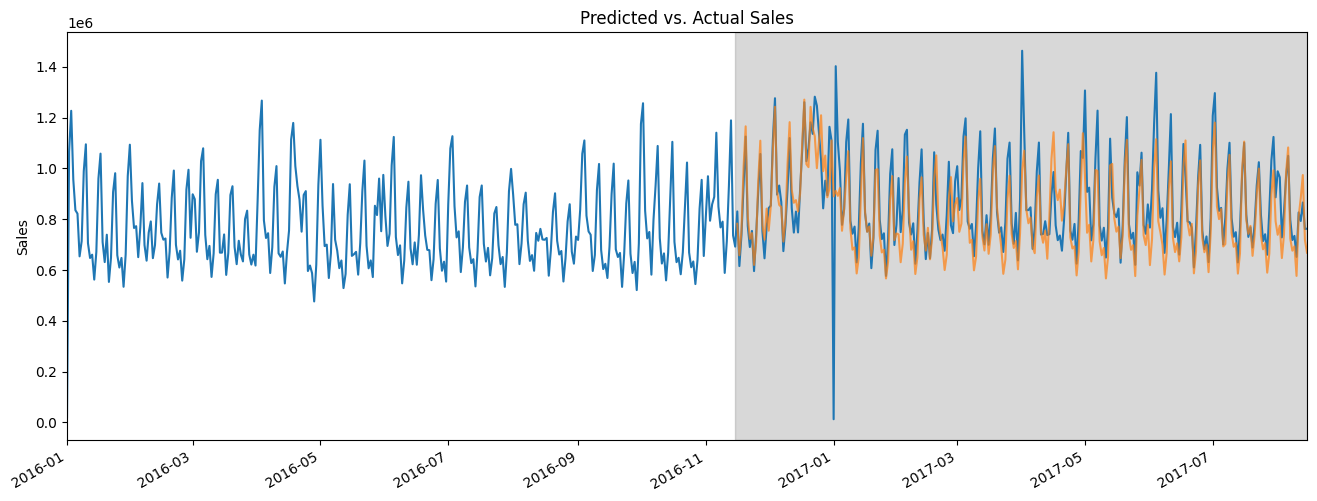

In [43]:
df.groupby('date').sales.sum().plot(ylabel='Sales', title='Predicted vs. Actual Sales', figsize=(16, 6));
pd.DataFrame({'date': X_test.date, 'sales': cbr_preds2}).groupby('date').sales.sum().plot(alpha=0.7)
plt.axvspan('2016-11-15', '2017-08-15', color='grey', alpha=0.3)
plt.xlim(('2016', '2017-08-15'))
plt.xlabel('');

### **Concluding Thoughts**
* Further feature engineering (e.g., a lagged sales or rolling average feature) and model optimisation could be explored.
* Compare current model performance against a local approach.
* I struggle to understand the merits of using cross-validation for time series. Unless the idea is that more training data does not necessarily lead to a better performing model. For simplicity, imagine a dataset is split successively for 3 folds where there are 41 observations in k1, 52 in k2, 63 in k3, and training sets of 29, 18, and 7 observations. Intuitively, training the model on k3 will result in a model that more accurately forecasts 7 timesteps. However, could it be possible that in some cases, training sets with fewer observations such as k1 perform better and therein lies the merit of cross-validation for time series? 